In [1]:
import re
import fitz  # PyMuPDF
from PIL import Image
from pptx import Presentation
from pptx.util import Inches, Pt
import io

from IPython.display import display, Image as IPImage

In [151]:
# Define the path to the PDF file
pdf_path = '检查报告_full.pdf'  # 替换为您的PDF文件路径

# Load the PDF
doc = fitz.open(pdf_path)

# Extract text from the first page
page = doc.load_page(13)
text = page.get_text()

In [152]:
# Define the regular expression patterns for extracting date and check items
date_pattern = re.compile(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}")
check_item_pattern = re.compile(r"检验项目[:：]\s*(.*?)(?:\n)")

# Using regular expressions to find '采集时间' and '检验项目'
date_match = date_pattern.search(text)
check_info_match = check_item_pattern.search(text)

date_info = date_match.group(0)[:10] if date_match else "采集时间未找到"
check_info = check_info_match.group(1) if check_info_match else "检验项目未找到"

# Print extracted information
print("采集时间:", date_info)
print("检验项目:", check_info)

采集时间: 2024-08-21
检验项目: 自免肝抗体组合


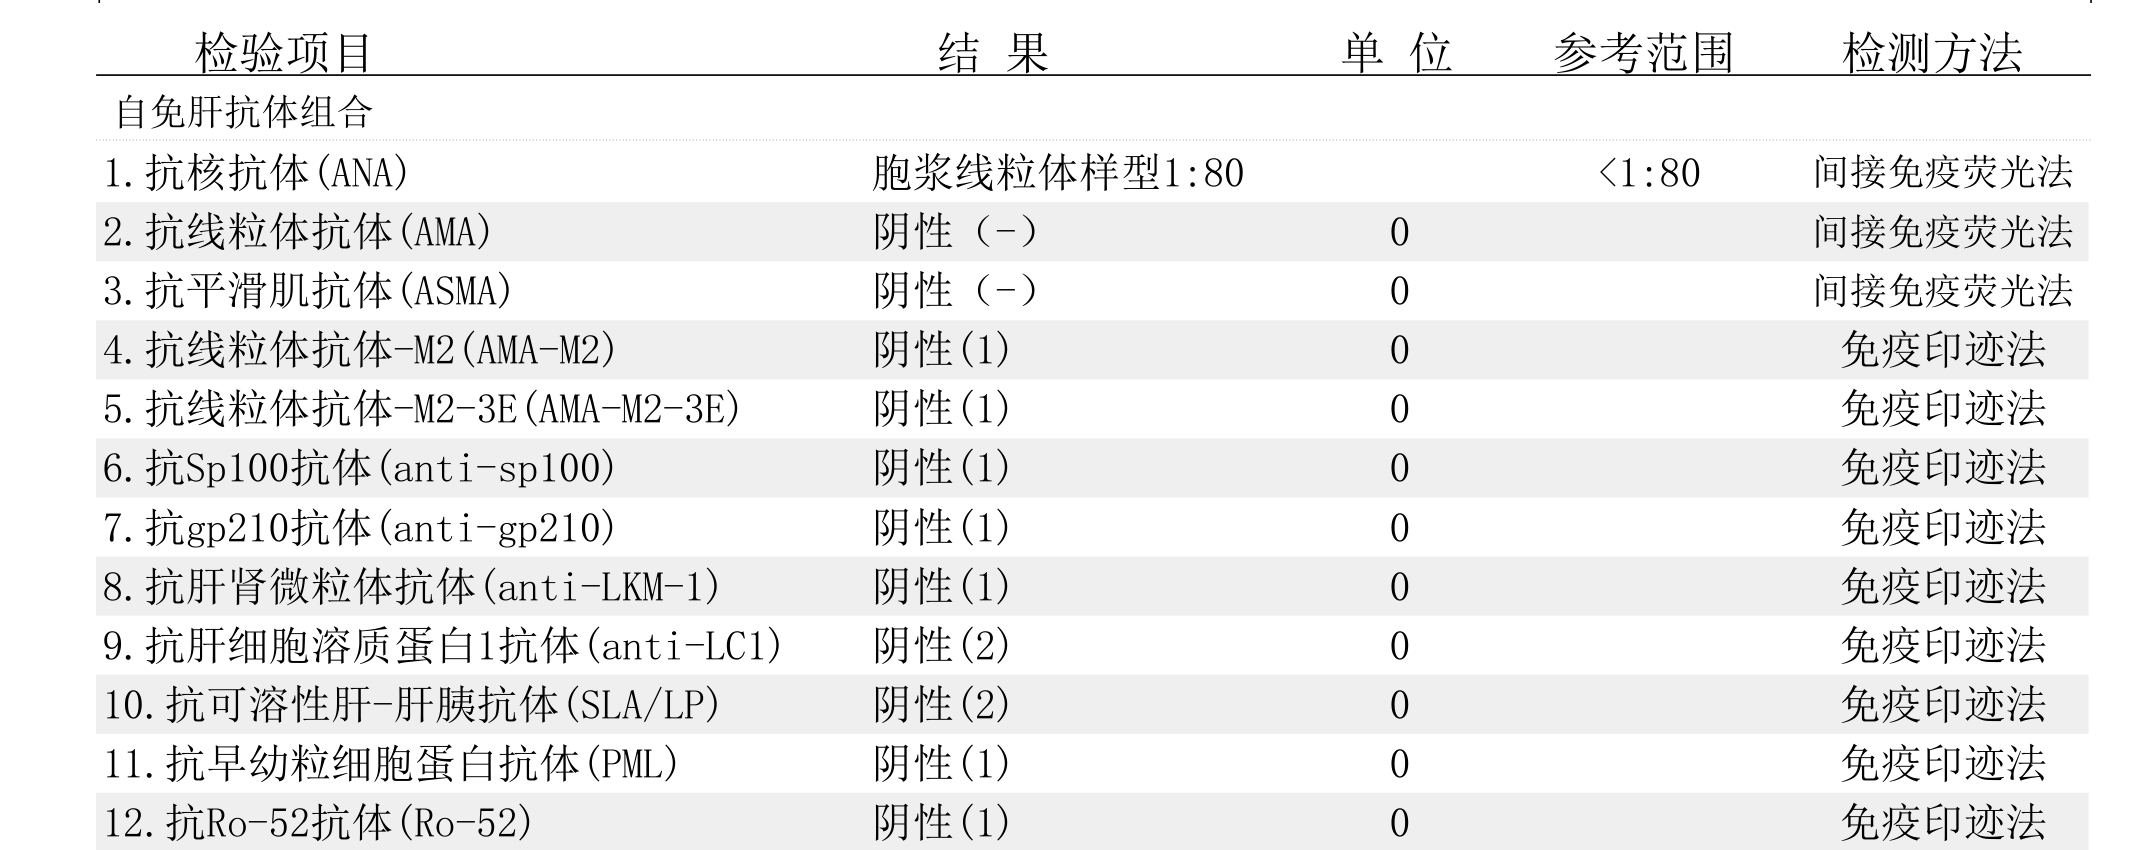

In [153]:
# Convert the first page to an image
pix = page.get_pixmap(dpi=300)
img = Image.open(io.BytesIO(pix.tobytes("png")))

# Initial crop (remove the top 16% and bottom 8.9% of the image)
width, height = img.size
cropped_img = img.crop((0, int(height * 0.16), width, int(height * 0.95)))

# Convert the cropped image to grayscale for easier processing
gray_img = cropped_img.convert("L")

# Scan from the top down to find the first row where black pixels > 60%
upper_bound = 0
threshold = 153  # Threshold for what we consider "black" (153/255 is approximately 60% darkness)
for y in range(gray_img.size[1]):
    row = gray_img.crop((0, y, gray_img.size[0], y + 1)).getdata()
    black_pixels = sum(1 for pixel in row if pixel < threshold)
    if black_pixels / width > 0.6:  # If more than 60% of the pixels are "black"
        upper_bound = y
        break

# Now scan from the bottom up to find the first row where black pixels > 60%
threshold = 153  # Same threshold for black pixels
lower_black_bound = gray_img.size[1]  # Initialize as the bottom of the image
for y in range(gray_img.size[1] - 1, -1, -1):
    row = gray_img.crop((0, y, gray_img.size[0], y + 1)).getdata()
    black_pixels = sum(1 for pixel in row if pixel < threshold)
    if black_pixels / width > 0.6:  # Found a row with >60% black pixels
        lower_black_bound = y
        break

# From the found row (lower_black_bound), move up two rows, then search for the first non-white row
lower_bound = lower_black_bound - 3
for y in range(lower_bound, -1, -1):
    row = gray_img.crop((0, y, gray_img.size[0], y + 1)).getdata()
    if min(row) < 255:  # Found the first non-white row above the black section
        lower_bound = y
        break

# Crop the image to remove unnecessary top and bottom white spaces
cropped_img = cropped_img.crop((0, upper_bound + 2, width, lower_bound - 2))

# Convert cropped image to bytes for displaying
img_byte_arr = io.BytesIO()
cropped_img.save(img_byte_arr, format='PNG')
img_byte_arr.seek(0)

# Display the cropped image using IPython.display
display(IPImage(data=img_byte_arr.getvalue()))


In [117]:
# Create a new PPT presentation
presentation = Presentation()

# Add a slide with a blank layout
slide = presentation.slides.add_slide(presentation.slide_layouts[6])  # 6 = Blank slide layout

# Add a title text box in the top-left corner
left = Inches(0.4)
top = Inches(0.1)
width = Inches(6)
height = Inches(0.8)

textbox = slide.shapes.add_textbox(left, top, width, height)
text_frame = textbox.text_frame
text_frame.word_wrap = True

# Set the title text
p = text_frame.add_paragraph()
p.text = f"{check_info} {date_info}"
p.font.size = Pt(18)
p.font.bold = True
p.font.name = 'Arial'

In [36]:
# 幻灯片的尺寸参数
slide_width = Inches(10)  # 幻灯片宽度
slide_height = Inches(6)  # 可用的幻灯片高度，留出顶部标题部分

# 将裁剪后的图像转换为字节流以便进一步处理
img_byte_arr = io.BytesIO()
cropped_img.save(img_byte_arr, format='PNG')
img_byte_arr.seek(0)

# 获取裁剪后图像的尺寸
cropped_width, cropped_height = cropped_img.size

# 计算图像的宽高比
image_ratio = cropped_width / cropped_height
slide_ratio = slide_width / slide_height

# 根据图像比例和幻灯片比例进行缩放
if image_ratio > slide_ratio:
    # 图像较宽，以幻灯片的宽度为基准缩放
    new_pic_width = slide_width
    new_pic_height = slide_width / image_ratio
else:
    # 图像较高，以幻灯片的高度为基准缩放
    new_pic_height = slide_height
    new_pic_width = slide_height * image_ratio

# 计算图像的居中位置
new_pic_left = (slide_width - new_pic_width) / 2
new_pic_top = (slide_height - new_pic_height) / 2 + Inches(1)  # 顶部预留1英寸给标题

# 添加图片到幻灯片，并根据计算的大小和位置进行放置
img_stream = io.BytesIO(img_byte_arr.getvalue())
slide.shapes.add_picture(img_stream, new_pic_left, new_pic_top, width=new_pic_width, height=new_pic_height)

# 保存PPT文件
ppt_output_path = 'output_presentation.pptx'  # 替换为您希望保存的PPT文件路径
presentation.save(ppt_output_path)
print(f"PPT saved at {ppt_output_path}")

PPT saved at output_presentation.pptx
